# EfficientNet

## Goal

- Accuracy, Loss for both train and val in graph
- Classification Report
  - Precision
  - Recall
  - F1-score
- Confusion Matrix
- Runtime performance

## Install Required Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


## Load Food-101 Dataset (First 10 Classes)

In [2]:
# Load Food-101 dataset
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# Get class names
class_names = info.features['label'].names[:10]

# Filter dataset to only include the first 10 classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_dataset = dataset.filter(filter_classes)

# Split into train and validation sets
train_split = 0.8
dataset_size = sum(1 for _ in filtered_dataset)
train_size = int(train_split * dataset_size)

train_ds = filtered_dataset.take(train_size)
val_ds = filtered_dataset.skip(train_size)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

## Visualize Sample Images

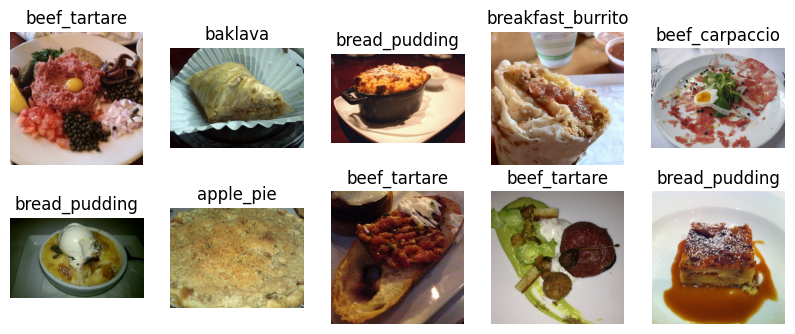

In [3]:
# Display images from the first 10 classes
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(filtered_dataset.take(10)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()

## Build EfficientNet Model

In [4]:
# Load EfficientNetB0 model (pretrained on ImageNet)
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(10, activation="softmax")(x)

# Compile model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

## Train Model (Before Fine-Tuning)

Epoch 1/30
    373/Unknown 40s 10ms/step - accuracy: 0.0992 - loss: 2.3264

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 85ms/step - accuracy: 0.0991 - loss: 2.3263 - val_accuracy: 0.0920 - val_loss: 2.3091
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.0995 - loss: 2.3065 - val_accuracy: 0.0927 - val_loss: 2.3046
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.1020 - loss: 2.3033 - val_accuracy: 0.0900 - val_loss: 2.3030
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.0993 - loss: 2.3036 - val_accuracy: 0.0900 - val_loss: 2.3028
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.1020 - loss: 2.3027 - val_accuracy: 0.0960 - val_loss: 2.3026
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.1057 - loss: 2.3032 - val_accuracy: 0.1107 - val_loss: 2.3043
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.0974 - loss: 2.3041 - val_accuracy: 0.1133 - val_loss: 2.3015
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.1011 - loss: 2.3040 - val_accurac

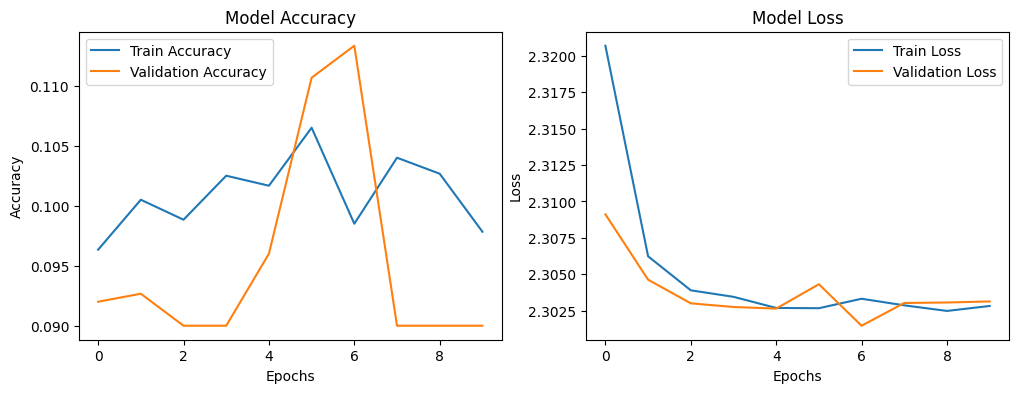

In [5]:
# Reduce batch size for better generalization
batch_size = 16
# Apply preprocessing
train_dataset = train_ds.map(preprocess).batch(batch_size).shuffle(1000)
val_dataset = val_ds.map(preprocess).batch(batch_size)

# epochs
epochs = 30

# Reduce learning rate for better optimization
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Train model
start_time = time.time()
# Train model with early stopping
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=epochs, callbacks=[early_stopping])
end_time = time.time()
initial_training_time = end_time - start_time

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Fine-Tuning

Epoch 1/30
    188/Unknown 141s 256ms/step - accuracy: 0.1286 - loss: 2.3982

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 170s 413ms/step - accuracy: 0.1287 - loss: 2.3979 - val_accuracy: 0.0780 - val_loss: 2.3037
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.2316 - loss: 2.1565 - val_accuracy: 0.0967 - val_loss: 2.3359
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.3153 - loss: 1.9569 - val_accuracy: 0.2753 - val_loss: 2.1118
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 144ms/step - accuracy: 0.4269 - loss: 1.7309 - val_accuracy: 0.5460 - val_loss: 1.5522
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.5046 - loss: 1.5272 - val_accuracy: 0.5653 - val_loss: 1.4470
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.5661 - loss: 1.3339 - val_accuracy: 0.6487 - val_loss: 1.1761
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.6228 - loss: 1.1679 - val_accuracy: 0.6187 - val_loss: 1.1944
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.6416 - loss: 1.0948 - va

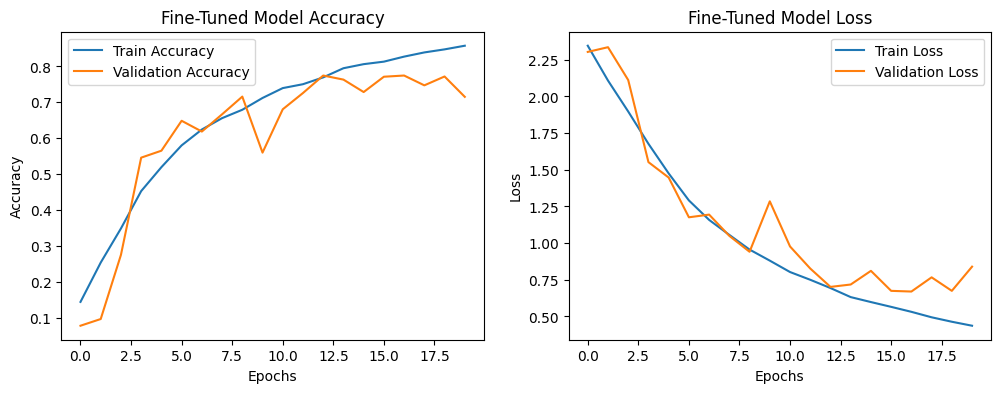

In [7]:
# Reduce batch size for better generalization
batch_size = 32

# Apply preprocessing
train_dataset = train_ds.map(preprocess).batch(batch_size).shuffle(1000)
val_dataset = val_ds.map(preprocess).batch(batch_size)

# epochs
epochs = 30

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile model with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Fine-tune model
start_time = time.time()
fine_tune_history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=epochs, callbacks=[early_stopping])
end_time = time.time()
fine_tuning_time = end_time - start_time

# Plot accuracy and loss after fine-tuning
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label="Train Accuracy")
plt.plot(fine_tune_history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Fine-Tuned Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label="Train Loss")
plt.plot(fine_tune_history.history['val_loss'], label="Validation Loss")
plt.title("Fine-Tuned Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Evaluate Model

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step
                   precision    recall  f1-score   support

        apple_pie       0.55      0.63      0.59       152
   baby_back_ribs       0.90      0.70      0.79       135
          baklava       0.71      0.80      0.75       138
   beef_carpaccio       0.81      0.77      0.79       155
     beef_tartare       0.73      0.80      0.76       157
       beet_salad       0.84      0.78      0.81       144
         beignets       0.89      0.87      0.88       170
         bibimbap       0.90      0.92      0.91       166
    bread_pudding       0.67      0.60      0.63       144
breakfast_burrito       0.78      0.86      0.82       139

         accuracy                           0.77      1500
        macro avg       0.78      0.77      0.77      1500
     weighted avg       0.78      0.77      0.78      1500

=== Initial Training ===
Average Training Accuracy: 0.1009
Average Validation Accuracy: 0.0955
Average Training Loss: 2.3051
Aver

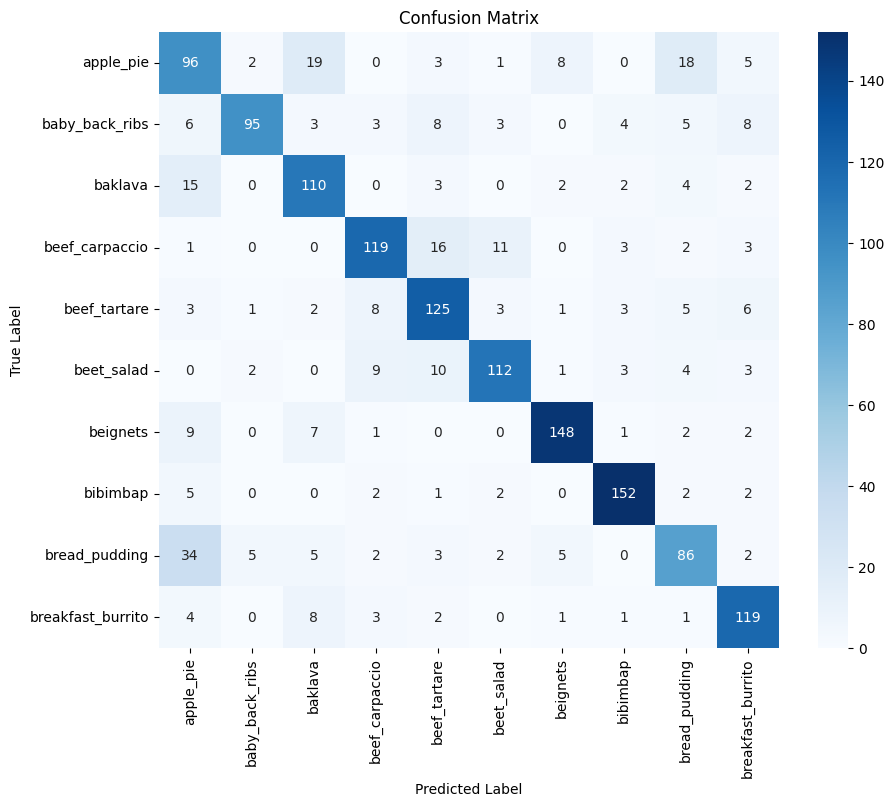

Initial Training Time: 329.02 seconds
Fine-Tuning Time: 886.66 seconds


In [8]:
# Generate predictions on validation dataset
# Store predictions in TensorFlow tensors (avoids NumPy conversion issues)
y_true = tf.concat([labels for _, labels in val_dataset], axis=0)
y_pred = tf.argmax(model.predict(val_dataset), axis=1)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)

# Calculate average accuracy and loss for training and validation (before fine-tuning)
avg_train_acc = np.mean(history.history['accuracy'])
avg_val_acc = np.mean(history.history['val_accuracy'])
avg_train_loss = np.mean(history.history['loss'])
avg_val_loss = np.mean(history.history['val_loss'])

# Calculate average accuracy and loss for training and validation (after fine-tuning)
avg_train_acc_fine = np.mean(fine_tune_history.history['accuracy'])
avg_val_acc_fine = np.mean(fine_tune_history.history['val_accuracy'])
avg_train_loss_fine = np.mean(fine_tune_history.history['loss'])
avg_val_loss_fine = np.mean(fine_tune_history.history['val_loss'])

# Display results
print("=== Initial Training ===")
print(f"Average Training Accuracy: {avg_train_acc:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}\n")

print("=== After Fine-Tuning ===")
print(f"Average Training Accuracy (Fine-Tuned): {avg_train_acc_fine:.4f}")
print(f"Average Validation Accuracy (Fine-Tuned): {avg_val_acc_fine:.4f}")
print(f"Average Training Loss (Fine-Tuned): {avg_train_loss_fine:.4f}")
print(f"Average Validation Loss (Fine-Tuned): {avg_val_loss_fine:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display runtime performance
print(f"Initial Training Time: {initial_training_time:.2f} seconds")
print(f"Fine-Tuning Time: {fine_tuning_time:.2f} seconds")